# day02 - И волки сыты

---

In [168]:
from random import randint, betavariate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta, date, time
import pylab
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15, 10)

---

## Моменты времени и протяженность во времени

Когда произошло событие? Сколько времени оно длилось? Эти два вопроса отличают моменты от продолжительности.  
Если уместно задать первый вопрос, или его аналог, то речь идет о моменте времени. Уместность второго вопроса свидетельствует о продолжительности. Данные по моментам и продолжительностям имеют разные сущности и требуют различные инструменты обработки при анализе. Рассмотрим на примере:

---

В файле *iCafe_train.xlsx* представлены данные одного дня интернет-кафе. Кафе принимает заказы на готовую еду и доставляет ее клиентам.  
Таблица содержит столбцы:
- Order_time - содержит информацию о времени размещения заказа на сайте, время представлено строкой вида 'h:mm:ss';
- Delivery_time - содержит информацию о времени, затраченном на доставку, время указано целым числом и характеризует количество минут, потребовавшихся на доставку от помещения кафе до клиента;
- Office - характеристика места доставки:
    - 1 - если доставка осуществлялась к месту работы клиента;
    - 0 - если доставка осуществлялась в жилой сектор. 

Нашей задачей будет определить, куда доставлялся заказ, на основании данных о времени его размещения и доставки.

Для решения задачи нам потребуется несколько библиотек. Часть из них уже импортированы в первой ячейке ноутбука, вторая часть появится по ходу решения задачи. Среди импортированных уже известные нам библиотеки numpy и matplotlib, а так же новые библиотеки:
- ***pandas*** - библиотека инструментов для работы с одномерными, двумерными и трехмерными структурами данных. Чаще всего работают с двумерными структурами данных (таблицами), которые называются датафреймами (DataFrame). Информация по pandas:
    - [Официальная документация](https://pandas.pydata.org)
    - [Краткий справочник на русском языке](https://pythonworld.ru/obrabotka-dannyx/pandas-cookbook-0-ipython.html)
- ***seaborn*** - библиотека инструментов визуализаци статистических данных. 
[Официальная документация](https://seaborn.pydata.org)

Для начала импортируем данные из файла:

In [169]:
# from google.colab import drive  # если вы выполняете код из среды Google Colab, нужно подключить свой гугл-диск,
# drive.mount('/content/drive')   # чтобы можно было оттуда считать файл с данными для этого задания

In [170]:
df = pd.read_excel('../datasets/iCafe_train.xlsx') # Создаем датафрейм df из файла
df.info()                                                            # Смотрим, что в нем располагается
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Order_time     280 non-null    object
 1   Delivery_time  280 non-null    int64 
 2   Office         280 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 6.7+ KB


,Order_time,Delivery_time,Office
0,0:03:35,12,0
1,0:07:14,6,1
2,0:11:30,9,1
3,0:13:48,12,0
4,0:14:36,2,1


Строковые значение столбца Order_time не удобны с точки зрения математического анализа и визуализации, поэтому необходимо преобразовать данные к другому виду. Создадим столбец Order_time_sec, в котором будет представлена информация о времени размещения заказа в секундах. Для этого воспользуемся двумя функциями:
- ***to_timedelta*** модуля pandas, которая распарсит строку времени и определит отклонение результата от 0;
- ***timedelta64*** модуля numpy, которая позволит нам получить в знаменателе 1 секунду и, соответственно, весь результат в секундах. Изменение параметра 's' на 'm' или на 'h' позволит получать результат в минутах и часах соответственно.

In [171]:
df['Order_time_sec'] = pd.to_timedelta(df.Order_time) // np.timedelta64(1,'s') # Создаем столбец
df                                                                             # Смотрим результат

,Order_time,Delivery_time,Office,Order_time_sec
0,0:03:35,12,0,215
1,0:07:14,6,1,434
2,0:11:30,9,1,690
3,0:13:48,12,0,828
4,0:14:36,2,1,876
...,...,...,...,...
275,23:39:14,3,1,85154
276,23:40:55,9,1,85255
277,23:45:19,6,1,85519
278,23:47:07,4,1,85627


In [172]:
df.describe()

,Delivery_time,Office,Order_time_sec
count,280.000000,280.000000,280.000000
mean,7.675000,0.650000,50935.935714
std,3.303862,0.477824,18926.037837
min,2.000000,0.000000,215.000000
25%,5.000000,0.000000,41675.250000
50%,8.000000,1.000000,45775.000000
75%,9.000000,1.000000,68300.000000
max,18.000000,1.000000,86178.000000


Начинать анализ следует с того, чтобы понять что вообще происходит, какие наблюдаются правила, зависимости, попытаться понять процесс...

Для этого лучше всего визуализировать данные. Далее мы построим несколько графиков и попытаемся их интерпретировать.

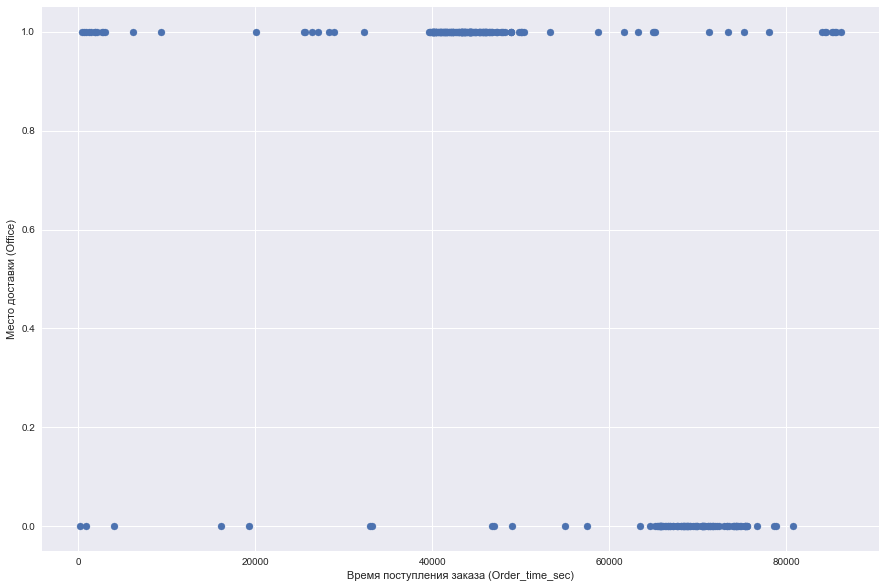

In [173]:
"""Строим график, где по оси абсцисс откладывается время поступления заказа, а по оси ординат место доставки"""

plt.scatter(df.Order_time_sec, df.Office)
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Место доставки (Office)')
plt.show()

Судя по графику, заказы в офис и не в офис по моменту поступления пересекаются, но кажется, что не очень сильно. Точнее мы сейчас определить не сможем.

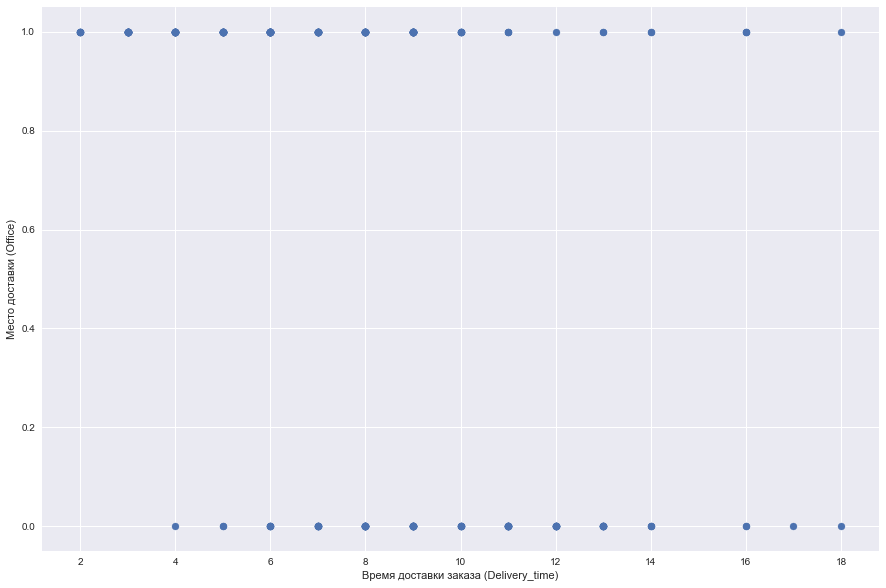

In [174]:
"""Строим график, где по оси абсцисс откладывается время доставки заказа, а по оси ординат место доставки"""

plt.scatter(df.Delivery_time, df.Office)
plt.xlabel('Время доставки заказа (Delivery_time)')
plt.ylabel('Место доставки (Office)')
plt.show()

Получили график, который не дает нам никакой информации. Это получилось в следствие того, что время доставки гораздо более дискретная величина, по сравнению с моментом размещения заказа, и у нас есть заказы из обоих классов почти для всех минут доставки. Построим другой график:

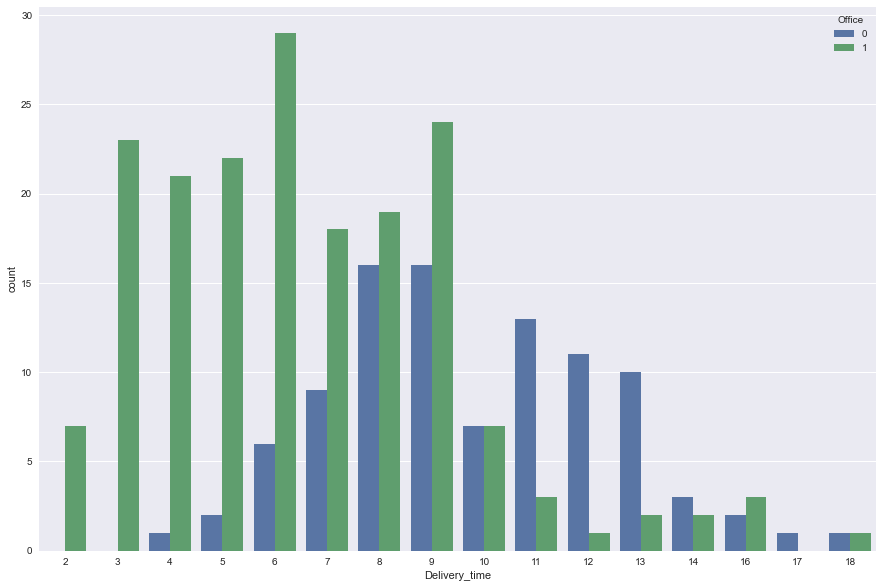

In [175]:
"""Строим диаграмму, где на каждое время доставки представлено количество доставок в офис и не в офис"""

sns.countplot(x = 'Delivery_time', hue = 'Office', data = df)
plt.show()

Из диаграммы мы видим, что в среднем в офис поставка осуществляется быстрее. Скорее всего помещение кафе располагается ближе к офисам, чем к жилым кварталам. Также мы видим, что чем дольше время доставки, тем меньше кафе получает заказов.

Попробуем построить подобный график для момента размещения заказа:

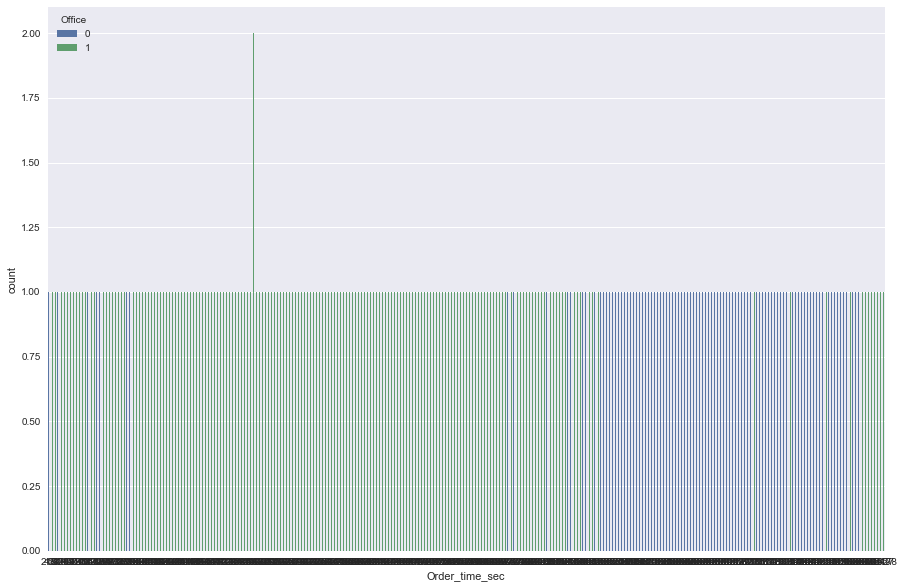

In [176]:
"""Строим диаграмму, где на каждое время размещения заказа представлено количество доставок в офис и не в офис"""

sns.countplot(x = 'Order_time_sec', hue = 'Office', data = df)
plt.show()

Опять получили лишенный смысла график. Здесь наблюдается обратная проблема. Заказы не поступают одноременно (за исключением одного случая, который следует рассматривать как случайное и крайне редкое событие). Для того, чтобы получить информативный график, нам необходимо собрать моменты поступления заказов во временные диапазоны, например, часовые. Создадим столбец Order_time_h, в который запишем час поступления заказа и построим диаграмму на полученных данных:

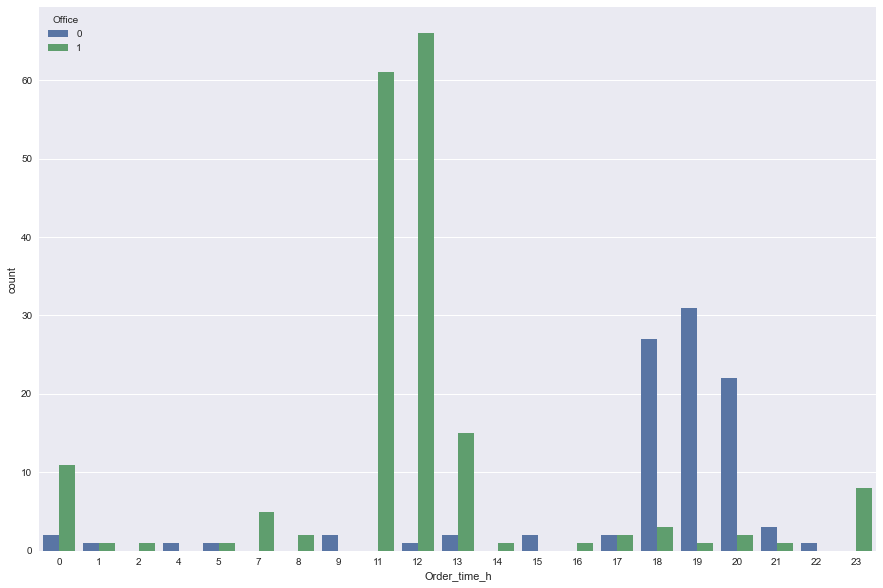

In [177]:
"""Строим диаграмму, где на каждый час времени размещения заказа представлено количество доставок 
   в офис и не в офис"""

df['Order_time_h'] = df.Order_time_sec//3600
sns.countplot(x = 'Order_time_h', hue = 'Office', data = df)
plt.show()

Вот теперь мы видим, что по моменту размещения заказа доля пересечения классов действительно не велика. Так же мы видим, что есть три больших всплеска заказов: 
- с 11 до 14 часов в офис - обеденный перерыв;
- с 18 до 22 часов на дом - для тех кто не хочет или не может готовить ужин;
- с 23 до 1 часа ночи в офис - дежурные на непрерывном производстве (например, тех. поддержка провайдеров)

Построим еще пару графиков. Постарайтесь их интерпретировать самостоятельно.

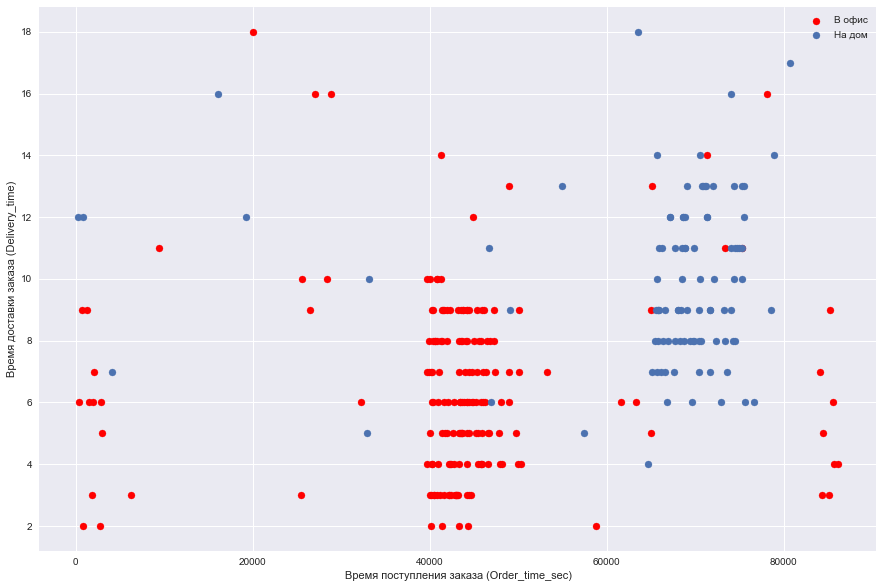

In [178]:
plt.scatter(df.Order_time_sec[df.Office == 1], df.Delivery_time[df.Office == 1], color = 'red')
plt.scatter(df.Order_time_sec[df.Office == 0], df.Delivery_time[df.Office == 0])
plt.legend(['В офис', 'На дом'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.show()

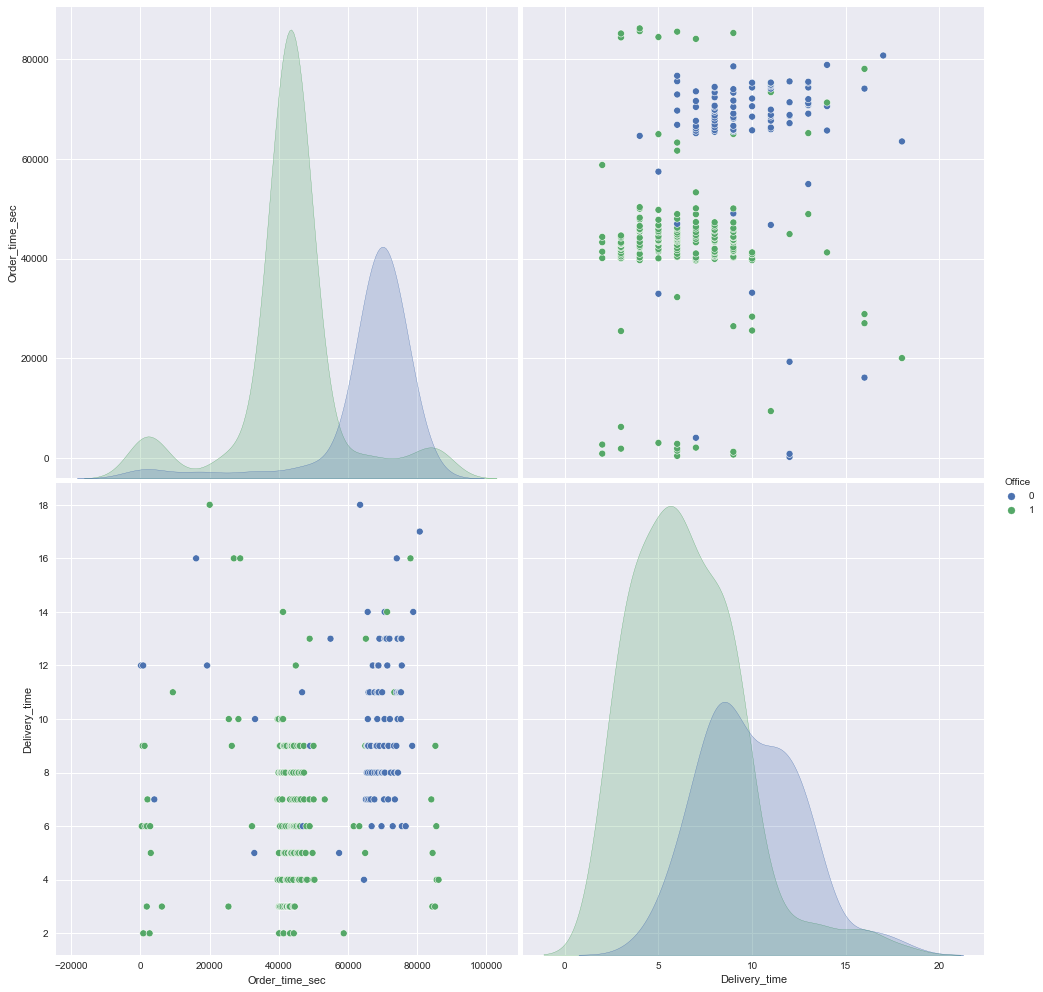

In [179]:
sns.pairplot(df[['Office', 'Order_time_sec', 'Delivery_time']], hue="Office", height=7)
plt.show()

---

### Разработка классификатора
***Логистическая регрессия***  
Настало время создать классификатор, который будет на основании данных о моменте размещения заказа и времени его доставки определять класс заказа (в офис, не в офис). Классификатор будем строить с помощью логистической регрессии:  
$$f(z)=\frac{1}{1+e^{-z}}$$
где *z* - это уравнение линейной регрессии по *n* признакам:
$$z=\theta_0+\sum_{i=1}^n {\theta_ix_i}$$
Поиск вектора $\bar{\theta}$ и является задачей классификации с помощью [логистической регрессии](https://habr.com/ru/company/io/blog/265007/).

***Метрики качества***  
Разработанный классификатор предсказывает к какому классу принадлежит объект на основании значений его признаков. В результате возможны четыре ситуации:
- Объект имеет характеристику класса 1 и классификатор определяет характеристику как 1. Это означает, что классификатор сработал верно. Величина ***TP*** (True positive) содержит общее количество таких ответов.
- Объект имеет характеристику класса 0, а классификатор определяет характеристику как 1. Это означает, что классификатор сработал не верно. Величина ***FP*** (False positive) содержит общее количество таких ответов.
- Объект имеет характеристику класса 0 и классификатор определяет характеристику как 0. Это означает, что классификатор сработал верно. Величина ***TN*** (True negative) содержит общее количество таких ответов.
- Объект имеет характеристику класса 1, а классификатор определяет характеристику как 0. Это означает, что классификатор сработал не верно. Величина ***FN*** (False negative) содержит общее количество таких ответов.    

Идеальный классификатор должен все определять верно, поэтому первая метрика ***Accuracy*** определяет долю правильных ответов и считается следующим образом:
$$Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$
Однако эту метрику рекомендуется использовать только для сбалансированных классов. Простой пример: если данные содержат 50 положительных объектов и 950 отрицательных, а классификатор настроен выдавть всегда отрицательный ответ, то *Accuracy = 0.95*, т.е. 95% правильных ответов при абсолютно бесполезном классификаторе.  
Второй метрикой качества является точность - ***Precision***, которая считается следующим образом:
$$Precision=\frac{TP}{TP+FP}$$
*Precision* определяет долю положительных объектов, среди положительных ответов классификатора.  
Следующая метрика называется полнотой - ***Recall***, определяет долю выявленных классификатором положительных объектов, и рассчитывается так:
$$Recall=\frac{TP}{TP+FN}$$
На практике часто требуются хорошие значения и точности, и полноты, поэтому было разработано множество показателей на основе обеих метрик. Наиболее известная метрика - это F-мера:
$$F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}} = \frac {(1 + \beta^2) \cdot \mathrm{TP} }{(1 + \beta^2) \cdot \mathrm{TP} + \beta^2 \cdot \mathrm{FN} + \mathrm{FP}}$$
F-мера - это среднее гармоническое точности и полноты. При плохих значениях одной из метрик (или обеих), F-мера устремляется к нулю. Параметр $\beta$ регулирует значимости метрик:
- Если $\beta>1$, то F-мера сильнее реагирует на долю ложноположительных ответов, т.е. на *Recall*;
- Если $\beta<1$, то F-мера чувствительнее к точности;
- Если $\beta=1$, то *Recall* и *Precision* равнозначны.
Часто используют именно метрику **$F_1$**:
$$F_1 = \frac{2\cdot\mathrm{precision} \cdot \mathrm{recall}}{ \mathrm{precision} + \mathrm{recall}}$$ 

Значительное отклонение метрик качества на обучающей и тестовой выборках может свидетельствовать о [переобучении модели](https://ru.wikipedia.org/wiki/Переобучение)

***scikit-learn***

Для разработки классификатора воспольземся библиотекой с инструментами машинного обучения [scikit-learn](https://scikit-learn.org/stable/) (sklearn).  
Нам потребуются 4 инструмента:
- ***classification_report*** из модуля [metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics) сформирует метрики *Accuracy*, *Precision*, *Recall* и $F_1$;
- ***train_test_split*** из модуля [model_selection](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn.model_selection#module-sklearn.model_selection) поможет разбить выборку на обучающую и тестовую;
- ***StandardScaler*** из модуля [preprocessing](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn.preprocessing#module-sklearn.preprocessing) поможет преобразовать данные к стандартному виду;
- ***LogisticRegression*** из модуля [linear_model](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn.linear_model#module-sklearn.linear_model) поможет подобрать коэффициенты для логистической регрессии.

In [180]:
"""Импортируем необходимые инструменты"""

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [181]:
"""Разрабатываем классификатор"""

y = df.Office                                   # Определяем результирующий признак
X = df[['Order_time_sec', 'Delivery_time']]     # Определяем признаки

"""С помощью функции train_test_split разбиваем выборку на обучающую и тестовую. Параметр test_size указывает на 
   долю тестовой выборки. Если параметр random_state отличен от None, т.е. имеет конкретное значение, то 
   генерируемые псевдослучайные величины будут иметь одни и те же значения при каждом вызове, и мы будем каждый 
   раз получать одинаковое разбиение на обучающую и тестовую выборки. Условимся, что, если не указано другое, то
   по всему курсу обучения random_state=21"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

"""Функция StandardScaler приведет значения признаков к стандартному виду z = (x-u)/s, где u - среднее значение,
   а s - стандартное отклонение. Расчет среднего значения и стандартного отклонение осуществляется на выборке для 
   обучения, затем осуществляется преобразования данных для обучения и тестовых данных """
sc = StandardScaler()
sc.fit(X_train)                                  # Находим среднее и стандартное отклонение обучающей выборки
X_train_std = sc.transform(X_train)              # Преобразовываем обучающую выборку
X_test_std = sc.transform(X_test)                # Преобразовываем тестовую выборку

"""Формируем классификатор с помощью LogisticRegression. Коэффициенты уравнения логистической регрессии находятся
   на обучающей выборке, затем с помощью найденного уравнения предсказывается класс объекта на тестовой выборке"""
lr = LogisticRegression(random_state=21)
lr.fit(X_train_std, y_train)                     # Находим коэффициенты уравнения логистической регрессии
y_pred = lr.predict(X_test_std)                  # Определяем класс на значениях тестовых данных

print(classification_report(y_test, y_pred))     # Публикуем результаты качества модели на тестовой выборке

              precision    recall  f1-score   support

           0       0.76      0.88      0.81        25
           1       0.93      0.84      0.88        45

    accuracy                           0.86        70
   macro avg       0.84      0.86      0.85        70
weighted avg       0.87      0.86      0.86        70



---

Для анализа полученного результата напишем функцию *Processing_results()*, которой передаются значения:
- sc - действующий (полученный при разработке классификатора) метод стандартизации данных;
- lr - классификатор;
- df - датафрейм;
- target - название столбца целевого признака;
- attribute_name - список названий столбцов признаков;
- name - строка названия анализируемого результата;
- add_schedule - список списков признаков, для которых необходимо построить дополнительные графики (необязательный параметр)

In [182]:
def Processing_results(sc, lr, df, target, attribute_name, name, add_schedule = []):
    X_std = sc.transform(df[attribute_name])
    new_col_name = []
    
    for i, col_name in enumerate(attribute_name):
        s = col_name + '_std_' + name
        df[s] = X_std[:,i]
        new_col_name.append(s)
        
    y_pred = 'y_pred_' + name
    Correct = 'Correct_' + name
    df[y_pred] = lr.predict(X_std)
    df[Correct] = df.Office == df[y_pred]
    print(classification_report(df.Office, df[y_pred]))
    sns.pairplot(df[[Correct] + new_col_name], hue = Correct, height=round(12/len(new_col_name), 1))
    plt.show()
    
    for k in range(len(add_schedule)):
        i,j = add_schedule[k]
        i = i+'_std_'+name
        j = j+'_std_'+name
        plt.scatter(df[i][True ^ df[Correct]], df[j][True ^ df[Correct]], color = 'red')
        plt.scatter(df[i][df[Correct]], df[j][df[Correct]])
        plt.legend(['Определены не верно', 'Определены верно'])
        plt.xlabel(i)
        plt.ylabel(j)
        plt.show()
        
    return df

              precision    recall  f1-score   support

           0       0.81      0.84      0.82        98
           1       0.91      0.90      0.90       182

    accuracy                           0.88       280
   macro avg       0.86      0.87      0.86       280
weighted avg       0.88      0.88      0.88       280



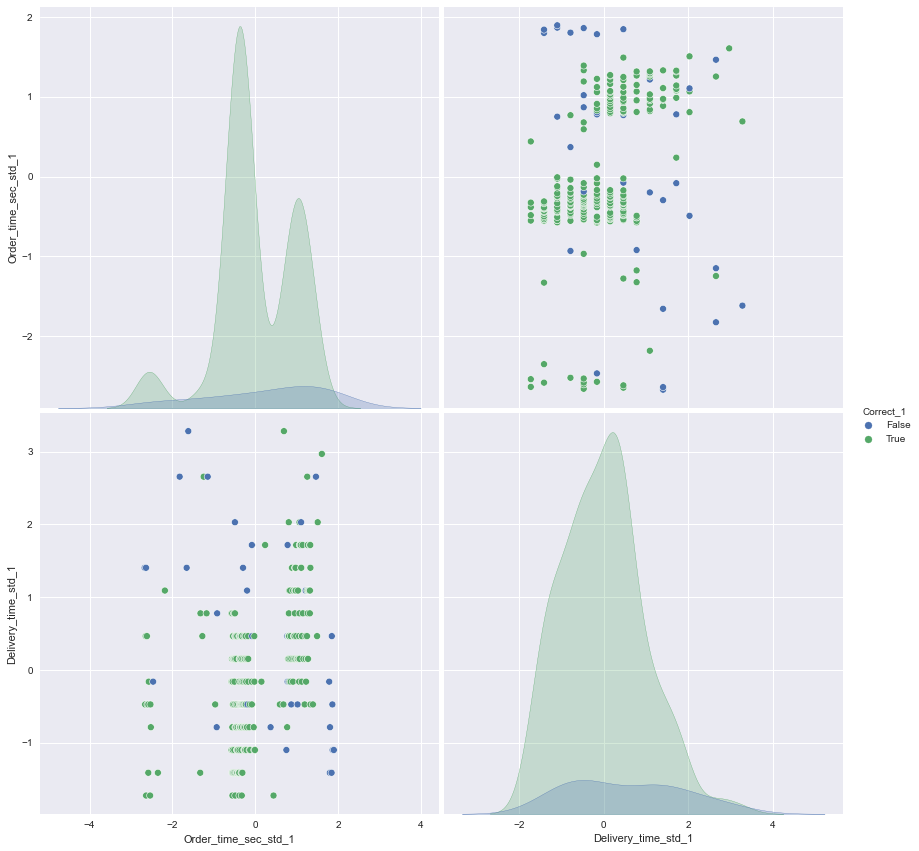

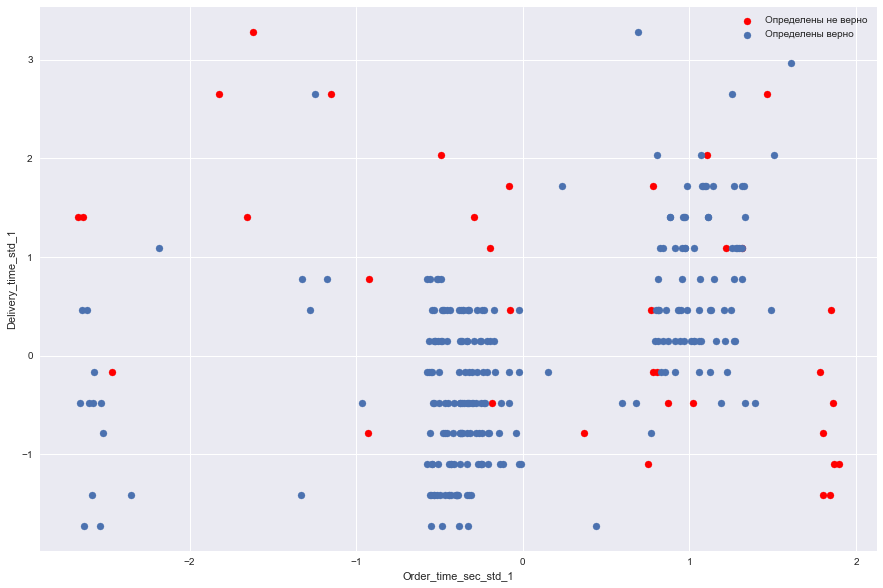

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True
...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False


In [183]:
y = 'Ofice'
x = ['Order_time_sec', 'Delivery_time']
df = Processing_results(sc, lr, df, y, x, '1', [x])
df

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.94      0.94      0.94        47

    accuracy                           0.91        68
   macro avg       0.90      0.90      0.90        68
weighted avg       0.91      0.91      0.91        68



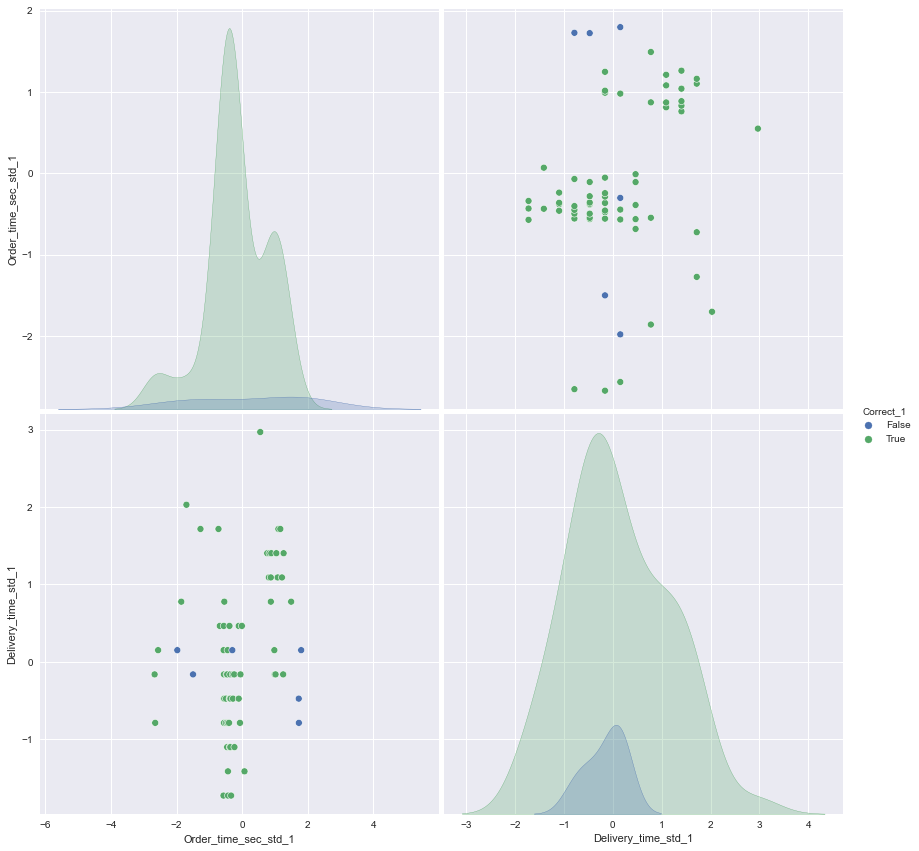

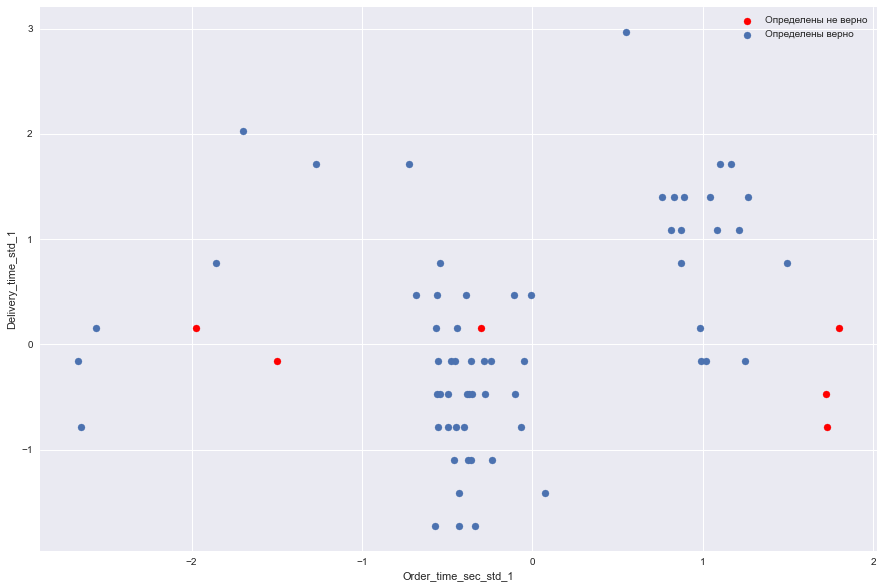

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1
0,0:04:24,7,1,264,-2.668392,-0.160937,1,True
1,0:10:10,5,1,610,-2.650011,-0.786802,1,True
2,0:37:54,8,1,2274,-2.561611,0.151996,1,True
3,3:41:23,8,0,13283,-1.976760,0.151996,1,False
4,4:19:15,10,1,15555,-1.856060,0.777861,1,True
...,...,...,...,...,...,...,...,...
63,20:37:29,12,0,74249,1.262051,1.403727,0,True
64,21:49:31,10,0,78571,1.491657,0.777861,0,True
65,23:02:09,6,1,82929,1.723175,-0.473870,0,False
66,23:03:24,5,1,83004,1.727160,-0.786802,0,False


In [184]:
df_test = pd.read_excel('../datasets/iCafe_test.xlsx')
df_test['Order_time_sec'] = pd.to_timedelta(df_test.Order_time)//np.timedelta64(1,'s')

y = 'Ofice'
x = ['Order_time_sec', 'Delivery_time']
df_test = Processing_results(sc, lr, df_test, y, x, '1', [x])
df_test

---

# Задание 1

Путем двойного контроля мы убедились, что модель не переобучена и демонстрирует не плохое качество, все метрики на общей обучающей выборке 0.88, на тестовой выборке - 0.91. Можно ли улучшить полученное решение? Для ответа на этот вопрос в начале еще раз посмотрим на графики:

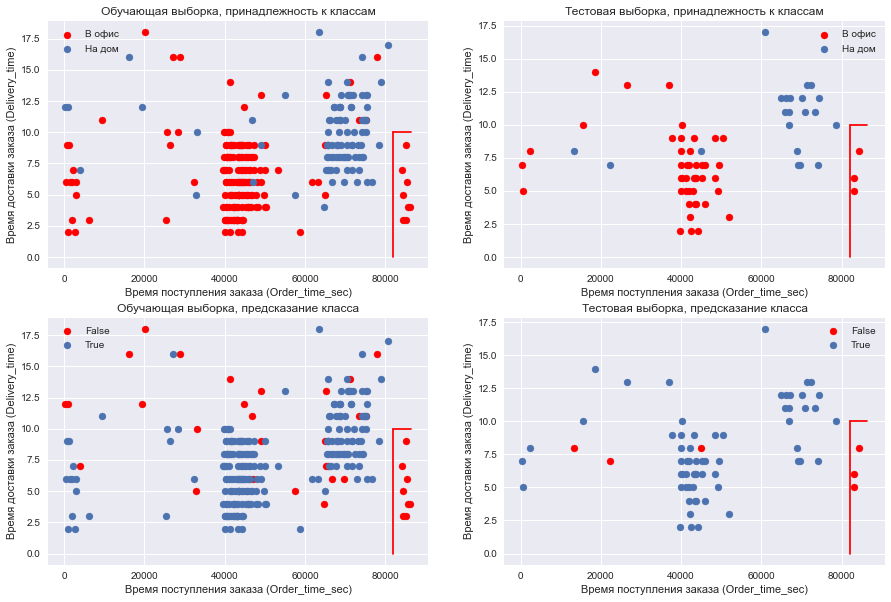

In [185]:
plt.subplot (2, 2, 1)
plt.scatter(df.Order_time_sec[df.Office == 1], df.Delivery_time[df.Office == 1], color = 'red')
plt.scatter(df.Order_time_sec[df.Office == 0], df.Delivery_time[df.Office == 0])
plt.legend(['В офис', 'На дом'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Обучающая выборка, принадлежность к классам')

plt.subplot (2, 2, 2)
plt.scatter(df_test.Order_time_sec[df_test.Office == 1], df_test.Delivery_time[df_test.Office == 1], color = 'red')
plt.scatter(df_test.Order_time_sec[df_test.Office == 0], df_test.Delivery_time[df_test.Office == 0])
plt.legend(['В офис', 'На дом'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Тестовая выборка, принадлежность к классам')

plt.subplot (2, 2, 3)
plt.scatter(df.Order_time_sec[True^df.Correct_1], df.Delivery_time[True^df.Correct_1], color = 'red')
plt.scatter(df.Order_time_sec[df.Correct_1], df.Delivery_time[df.Correct_1])
plt.legend(['False', 'True'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Обучающая выборка, предсказание класса')

plt.subplot (2, 2, 4)
plt.scatter(df_test.Order_time_sec[True^df_test.Correct_1], df_test.Delivery_time[True^df_test.Correct_1], 
            color = 'red')
plt.scatter(df_test.Order_time_sec[df_test.Correct_1], df_test.Delivery_time[df_test.Correct_1])
plt.legend(['False', 'True'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Тестовая выборка, предсказание класса')
plt.show()

На графиках мы видим одну и ту же область, где представители одного класса предсказываются неверно как на обучающей, так и на тестовой выборке. Попробуем исправить это!

1. Вам необходимо написать функцию time_change(df), которая записывает в датафрейм df столбец Order_time_sec_delta и возвращает полученный датафрейм. Столбец Order_time_sec_delta отличается от столбца Order_time_sec константой. В столбце Order_time_sec отметки времени расположены так, что последний заказ "на дом" (Office = 0) оказывается на отметке 86399 секунд от начала дня (т.е. ровно через сутки после начала). В этой функции нужно "сдвинуть" время всех заказов циклично влево, ближе к началу дня, на дельту, равную разнице \[24 часа - максимальное время заказа на дом во всем датафрейме].
2. Вам необходимо написать функцию log_reg(y, X), которая принимает на вход целевой признак y и столбцы датафрейма X, представляющие собой признаки. Функция возвращает обученные объекты sc и lr

In [186]:
my_df = df.copy()

In [187]:
my_df

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True
...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False


---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---

# Выполнение задания 1

In [188]:
"""Выполнение задания 1"""

def time_change(df):
    delta = 86400 - my_df[my_df['Office'] == 0]['Order_time_sec'].max()
    df['Order_time_sec_delta'] = df['Order_time_sec'] - delta
    df.loc[(df['Order_time_sec_delta'] < 0), ('Order_time_sec_delta')] += 86399
    return df

def log_reg(y,X):
    sc = StandardScaler()
    lr = LogisticRegression(random_state=21)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)
    
    
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    lr.fit(X_train_std, y_train)
    y_pred = lr.predict(X_test_std)
    
    print(classification_report(y_test, y_pred))
    
    return sc, lr

---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---

              precision    recall  f1-score   support

           0       0.76      0.88      0.81        25
           1       0.93      0.84      0.88        45

    accuracy                           0.86        70
   macro avg       0.84      0.86      0.85        70
weighted avg       0.87      0.86      0.86        70

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        98
           1       0.90      0.88      0.89       182

    accuracy                           0.86       280
   macro avg       0.84      0.85      0.84       280
weighted avg       0.86      0.86      0.86       280



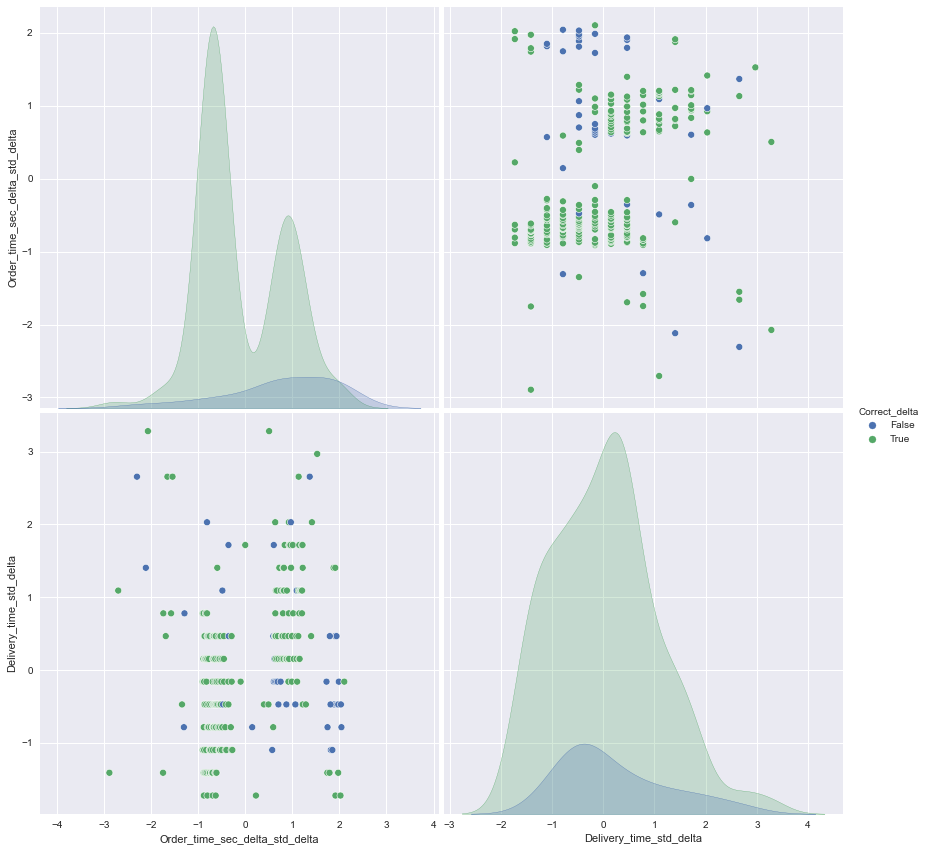

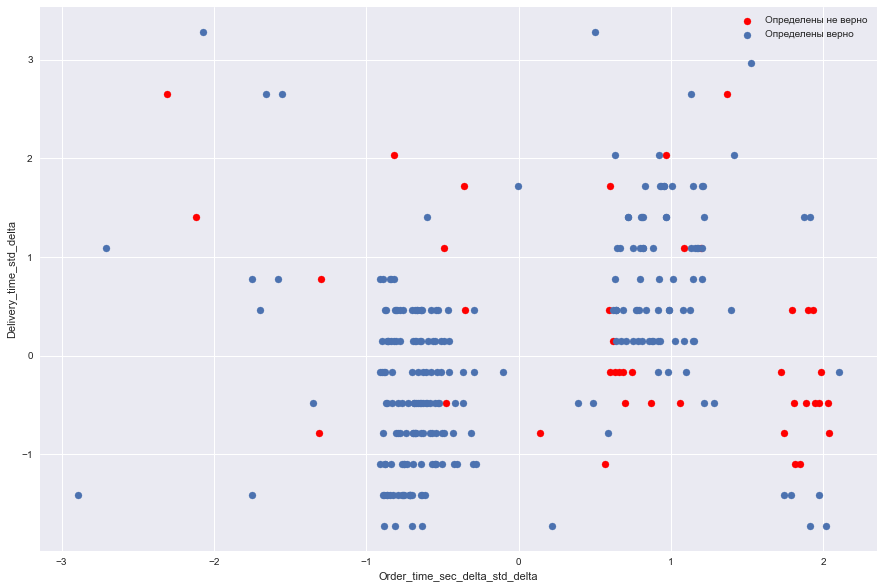

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1,Order_time_sec_delta,Order_time_sec_delta_std_delta,Delivery_time_std_delta,y_pred_delta,Correct_delta
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False,80951,1.874372,1.403727,0,True
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True,81170,1.887364,-0.473870,0,False
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True,81426,1.902551,0.464929,0,False
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False,81564,1.910738,1.403727,0,True
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True,81612,1.913585,-1.725600,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False,79491,1.787760,-1.412668,1,True
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False,79592,1.793751,0.464929,0,False
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False,79856,1.809413,-0.473870,0,False
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False,79964,1.815820,-1.099735,0,False


In [189]:
"""Запустите, после написания функций"""

df = time_change(df)
y = 'Office'
x = ['Order_time_sec_delta', 'Delivery_time']
sc_delta, lr_delta = log_reg(df[y], df[x])
df = Processing_results(sc_delta, lr_delta, df, y, x, 'delta', [x])
df

              precision    recall  f1-score   support

           0       0.73      0.76      0.74        21
           1       0.89      0.87      0.88        47

    accuracy                           0.84        68
   macro avg       0.81      0.82      0.81        68
weighted avg       0.84      0.84      0.84        68



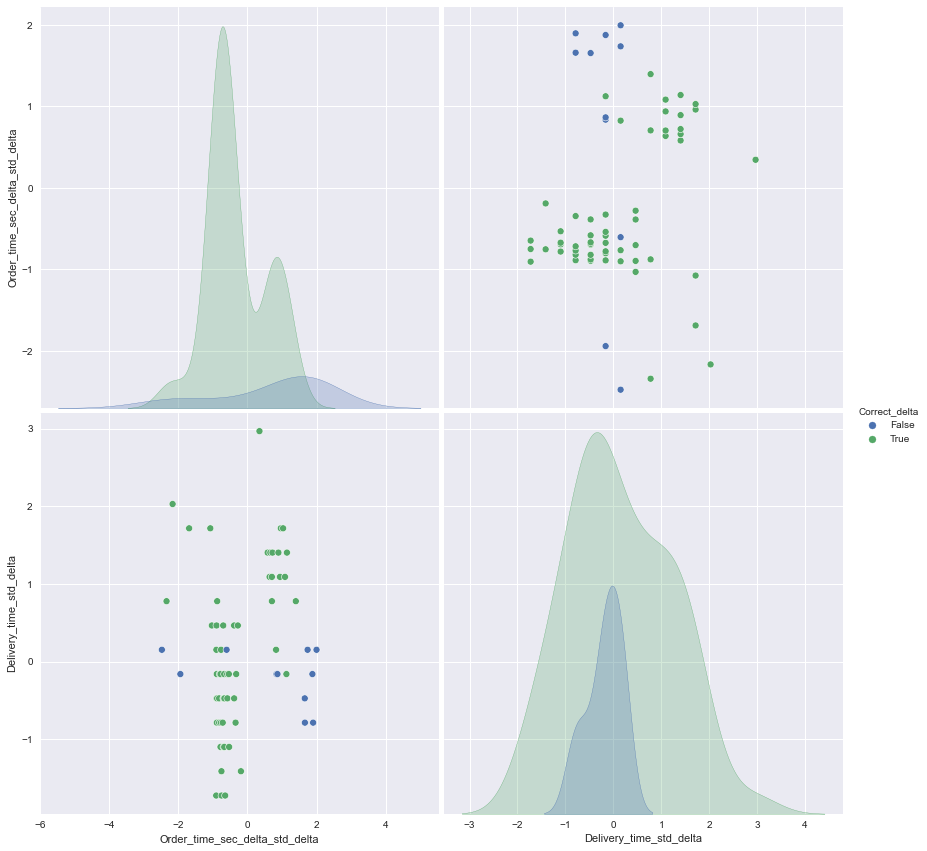

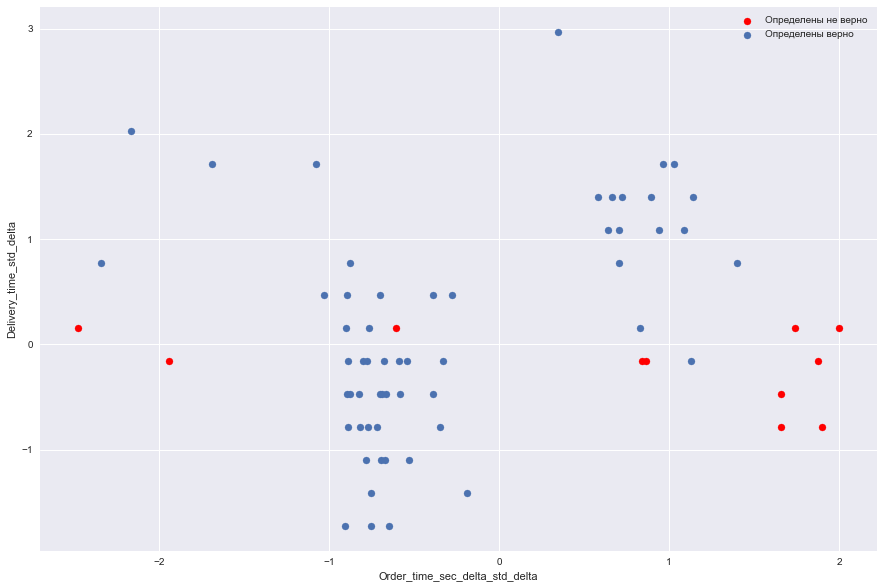

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1,Order_time_sec_delta,Order_time_sec_delta_std_delta,Delivery_time_std_delta,y_pred_delta,Correct_delta
0,0:04:24,7,1,264,-2.668392,-0.160937,1,True,81000,1.877279,-0.160937,0,False
1,0:10:10,5,1,610,-2.650011,-0.786802,1,True,81346,1.897805,-0.786802,0,False
2,0:37:54,8,1,2274,-2.561611,0.151996,1,True,83010,1.996520,0.151996,0,False
3,3:41:23,8,0,13283,-1.976760,0.151996,1,False,7620,-2.475896,0.151996,1,False
4,4:19:15,10,1,15555,-1.856060,0.777861,1,True,9892,-2.341113,0.777861,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,20:37:29,12,0,74249,1.262051,1.403727,0,True,68586,1.140834,1.403727,0,True
64,21:49:31,10,0,78571,1.491657,0.777861,0,True,72908,1.397232,0.777861,0,True
65,23:02:09,6,1,82929,1.723175,-0.473870,0,False,77266,1.655764,-0.473870,0,False
66,23:03:24,5,1,83004,1.727160,-0.786802,0,False,77341,1.660214,-0.786802,0,False


In [190]:
"""Запустите, если сработала предыдущая ячейка"""

df_test = time_change(df_test)
y = 'Office'
x = ['Order_time_sec_delta', 'Delivery_time']
df_test = Processing_results(sc_delta, lr_delta, df_test, y, x, 'delta', [x])
df_test

***Рекомендуется выполнить задание перед рассмотрением дальнейшего материала***

---

Мы улучшили качество классификатора за счет обеспечения монотонности целевой переменной от признаков, т.е. теперь выполняютя правила:
- чем больше момент времени поступления заказа, тем выше вероятность доставки на дом;
- чем выше время доставки, тем выше вероятность вероятность доставки на дом.

К сожалению, не всегда есть возможность обеспечить монотонность целевой переменной от признаков без применения каких-нибудь дополнительных инструментов.

Можно ли улучшить качество классификатора еще каким-нибудь способом? Это не только возможно, но и необходимо. 

Одним из способов улучшения классификатора является увеличение порядка пространства признаков, например, если на плоскости достаточно тяжело провести линию, разделяющую классы, то в трехмерном пространстве уже можно найти плоскость, которая сделает это лучше.

Все моменты времени необходимо преобразовывать через синус и косинус, формируя тем самым вместо одного два признака. Это становится тем более важным, если у нас вместо одного временного периода имеется несколько и существует возможность периодических колебаний.

Преобразования производятся по следующим формулам:
$$z_{sin} = sin\left(\frac{2\cdot\mathrm{\pi} \cdot \mathrm{x}}{ \mathrm{K} }\right)$$ 
$$z_{cos} = cos\left(\frac{2\cdot\mathrm{\pi} \cdot \mathrm{x}}{ \mathrm{K} }\right)$$ 

Здесь х - это значение момента времени, а К - значение временного периода в единицах измерения моментов времени.
Например: 
- если моменты времени измеряются в секундах, а временной период равен суткам, то К=86400;
- если моменты времени измеряются в днях, а временной период равен неделе, то К=7.

Проведем преобразование времени поступления заказа:

In [191]:
df['Order_sin'] = np.sin(df.Order_time_sec*math.pi/43200)
df['Order_cos'] = np.cos(df.Order_time_sec*math.pi/43200)
df

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1,Order_time_sec_delta,Order_time_sec_delta_std_delta,Delivery_time_std_delta,y_pred_delta,Correct_delta,Order_sin,Order_cos
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False,80951,1.874372,1.403727,0,True,0.015635,0.999878
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True,81170,1.887364,-0.473870,0,False,0.031556,0.999502
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True,81426,1.902551,0.464929,0,False,0.050157,0.998741
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False,81564,1.910738,1.403727,0,True,0.060177,0.998188
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True,81612,1.913585,-1.725600,1,True,0.063661,0.997972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False,79491,1.787760,-1.412668,1,True,-0.090488,0.995898
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False,79592,1.793751,0.464929,0,False,-0.083171,0.996535
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False,79856,1.809413,-0.473870,0,False,-0.064024,0.997948
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False,79964,1.815820,-1.099735,0,False,-0.056185,0.998420


Построим графики целевого показателя в пространстве полученных признаков:

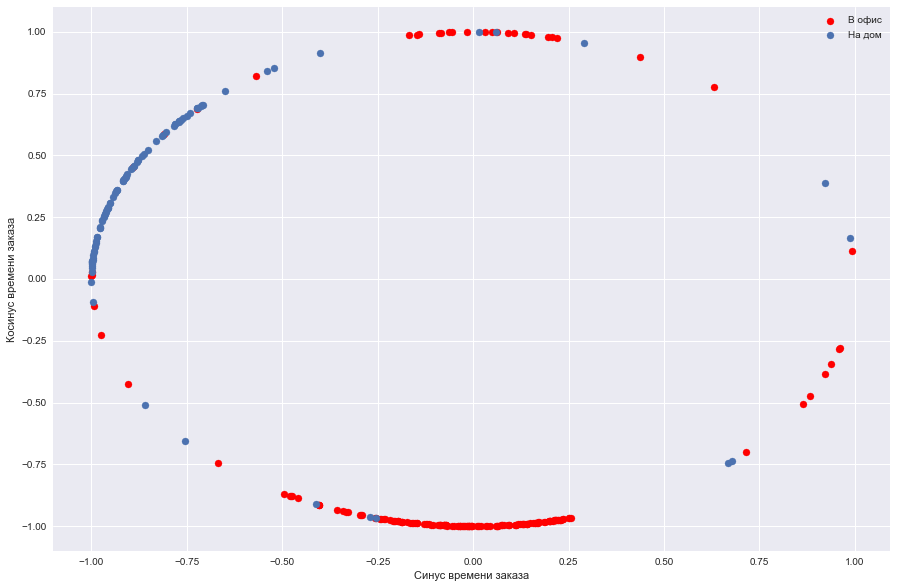

In [192]:
plt.scatter(df.Order_sin[df.Office == 1], df.Order_cos[df.Office == 1], color = 'red')
plt.scatter(df.Order_sin[df.Office == 0], df.Order_cos[df.Office == 0])
plt.legend(['В офис', 'На дом'])
plt.xlabel('Синус времени заказа')
plt.ylabel('Косинус времени заказа')
plt.show()

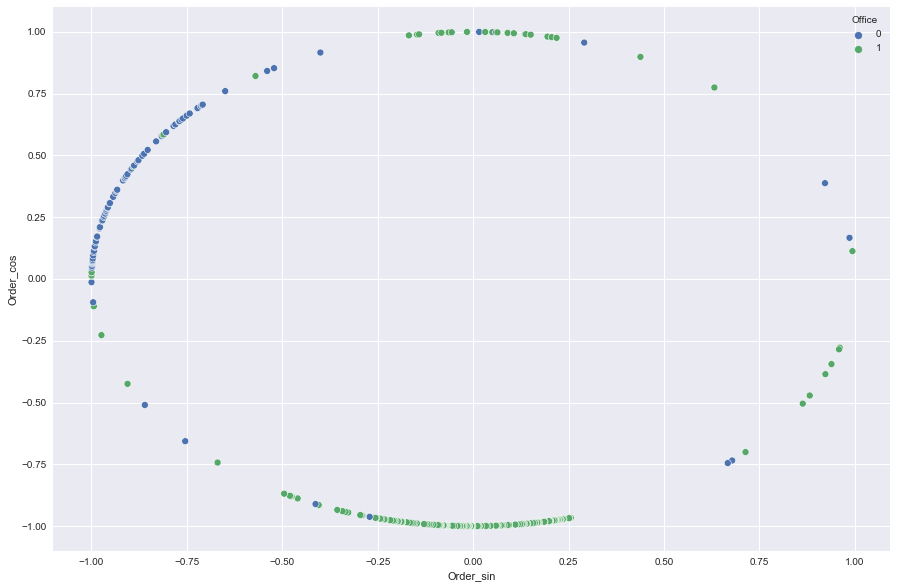

In [193]:
sns.scatterplot(x = 'Order_sin', y = 'Order_cos', data = df, hue = 'Office')
plt.show()

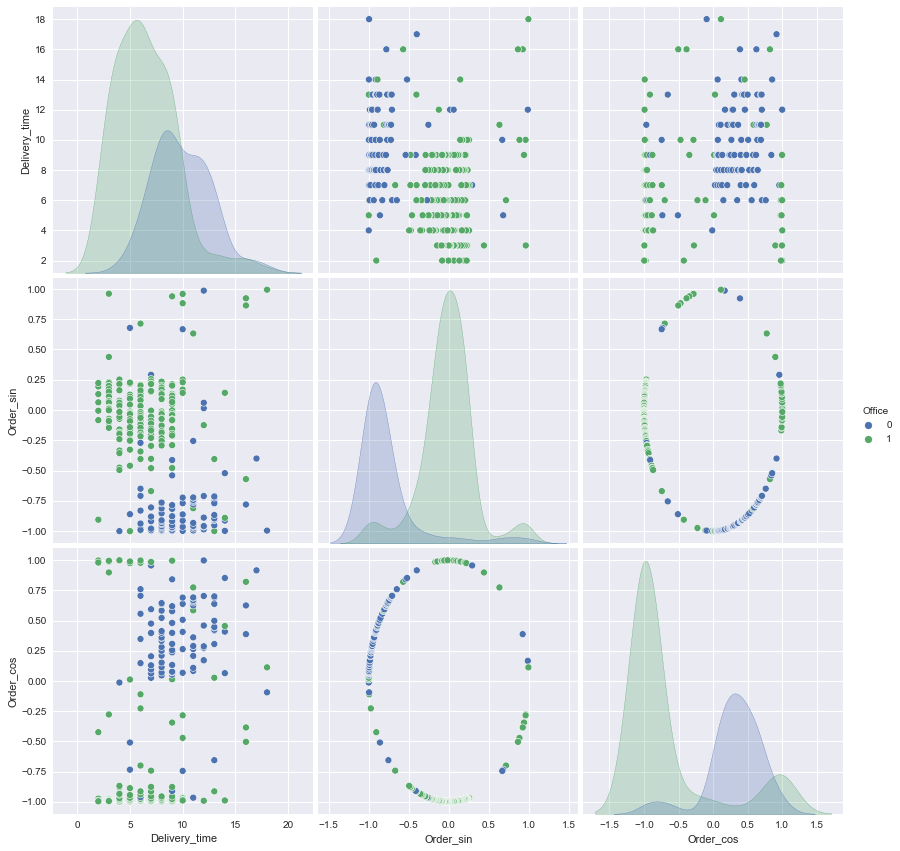

In [194]:
sns.pairplot(df[['Office', 'Delivery_time', 'Order_sin', 'Order_cos']], hue="Office", height=4)
plt.show()

Построим классификатор на преобразованых данных

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        25
           1       0.96      0.96      0.96        45

    accuracy                           0.94        70
   macro avg       0.94      0.94      0.94        70
weighted avg       0.94      0.94      0.94        70

              precision    recall  f1-score   support

           0       0.90      0.91      0.90        98
           1       0.95      0.95      0.95       182

    accuracy                           0.93       280
   macro avg       0.92      0.93      0.93       280
weighted avg       0.93      0.93      0.93       280



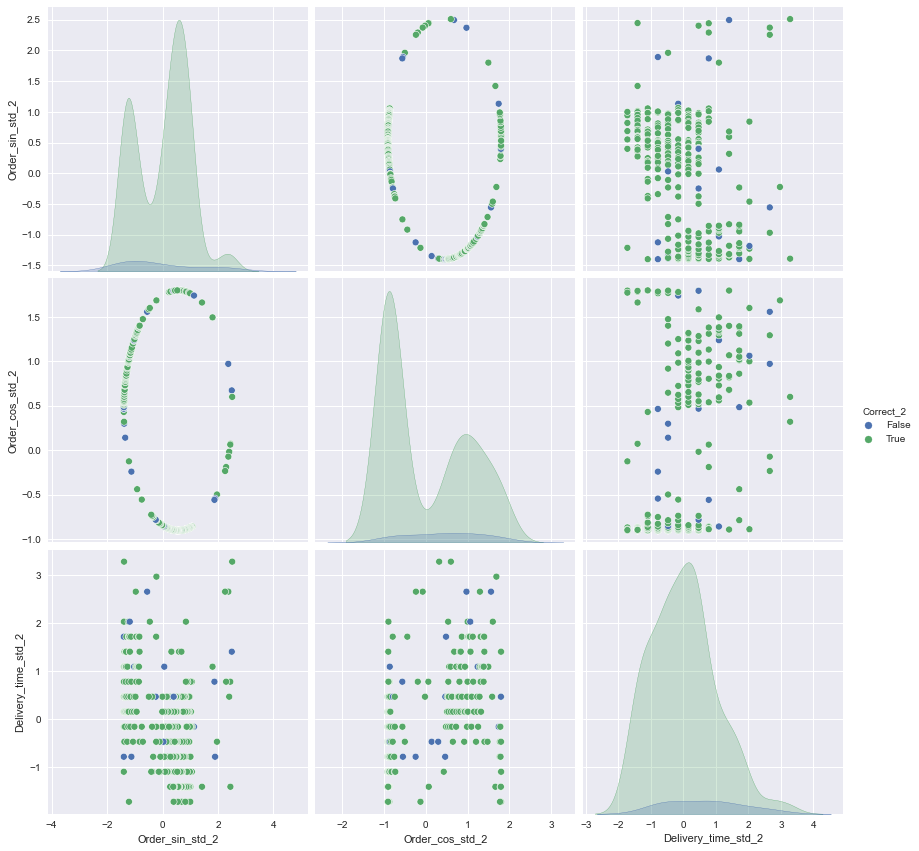

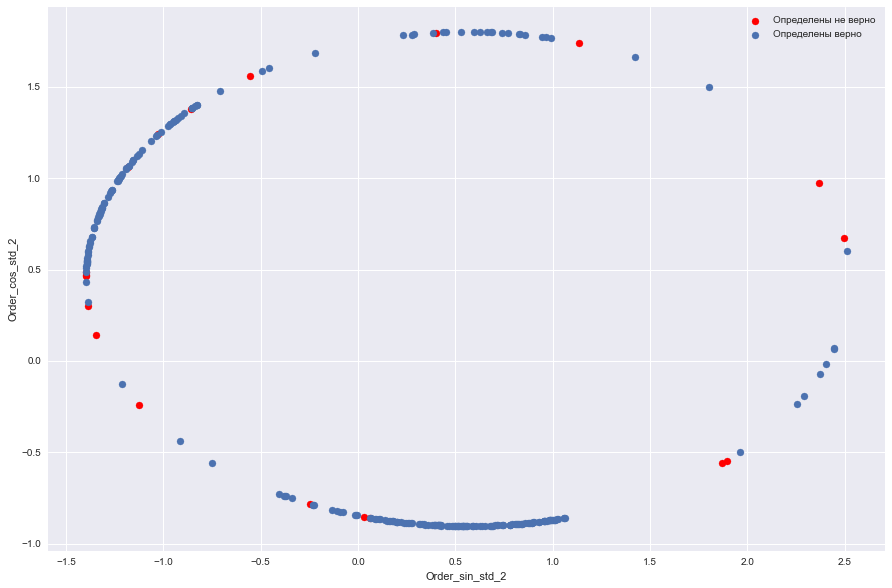

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1,Order_time_sec_delta,...,Delivery_time_std_delta,y_pred_delta,Correct_delta,Order_sin,Order_cos,Order_sin_std_2,Order_cos_std_2,Delivery_time_std_2,y_pred_2,Correct_2
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False,80951,...,1.403727,0,True,0.015635,0.999878,0.593465,1.799898,1.403727,0,True
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True,81170,...,-0.473870,0,False,0.031556,0.999502,0.624683,1.799390,-0.473870,1,True
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True,81426,...,0.464929,0,False,0.050157,0.998741,0.661154,1.798362,0.464929,1,True
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False,81564,...,1.403727,0,True,0.060177,0.998188,0.680801,1.797614,1.403727,0,True
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True,81612,...,-1.725600,1,True,0.063661,0.997972,0.687632,1.797322,-1.725600,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False,79491,...,-1.412668,1,True,-0.090488,0.995898,0.385390,1.794518,-1.412668,1,True
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False,79592,...,0.464929,0,False,-0.083171,0.996535,0.399737,1.795380,0.464929,0,False
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False,79856,...,-0.473870,0,False,-0.064024,0.997948,0.437277,1.797290,-0.473870,1,True
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False,79964,...,-1.099735,0,False,-0.056185,0.998420,0.452649,1.797928,-1.099735,1,True


In [195]:
y = df.Office
X = df[['Order_sin', 'Order_cos', 'Delivery_time']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

sc_2 = StandardScaler()
sc_2.fit(X_train)
X_train_std = sc_2.transform(X_train)
X_test_std = sc_2.transform(X_test)

lr_2 = LogisticRegression(random_state=21)
lr_2.fit(X_train_std, y_train)

y_pred_2 = lr_2.predict(X_test_std)

print(classification_report(y_test, y_pred_2))

y = 'Office'
X = ['Order_sin', 'Order_cos', 'Delivery_time']
x = ['Order_sin', 'Order_cos']
df = Processing_results(sc_2, lr_2, df, y, X, '2', [x])
df

              precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           1       0.94      0.98      0.96        47

    accuracy                           0.94        68
   macro avg       0.94      0.92      0.93        68
weighted avg       0.94      0.94      0.94        68



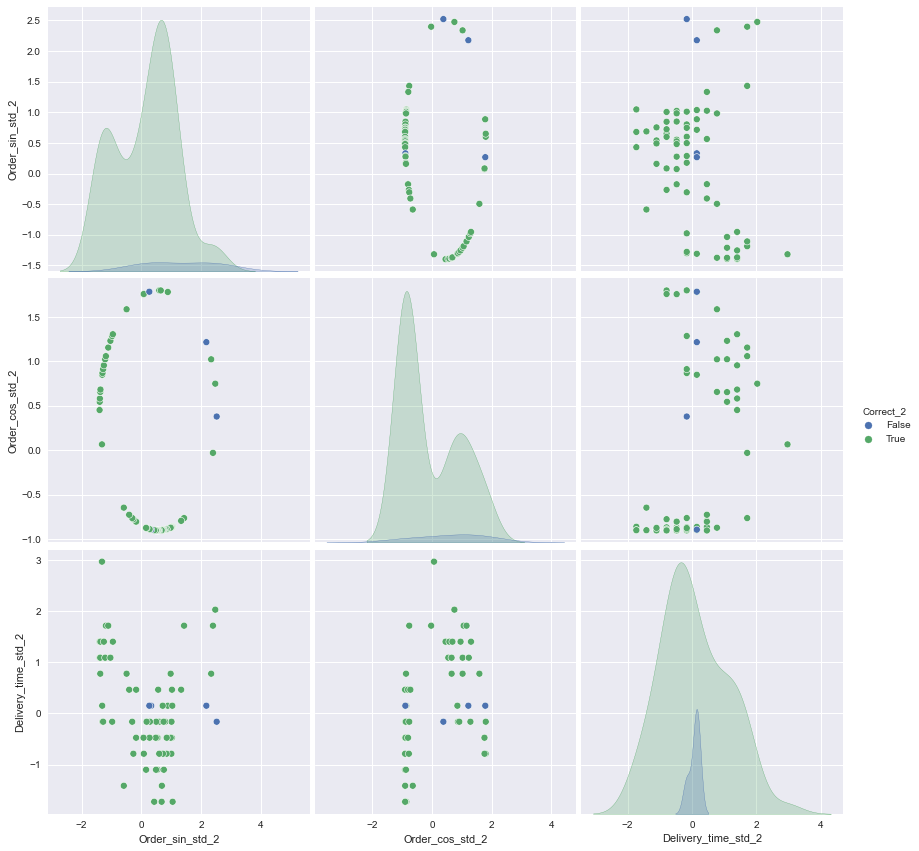

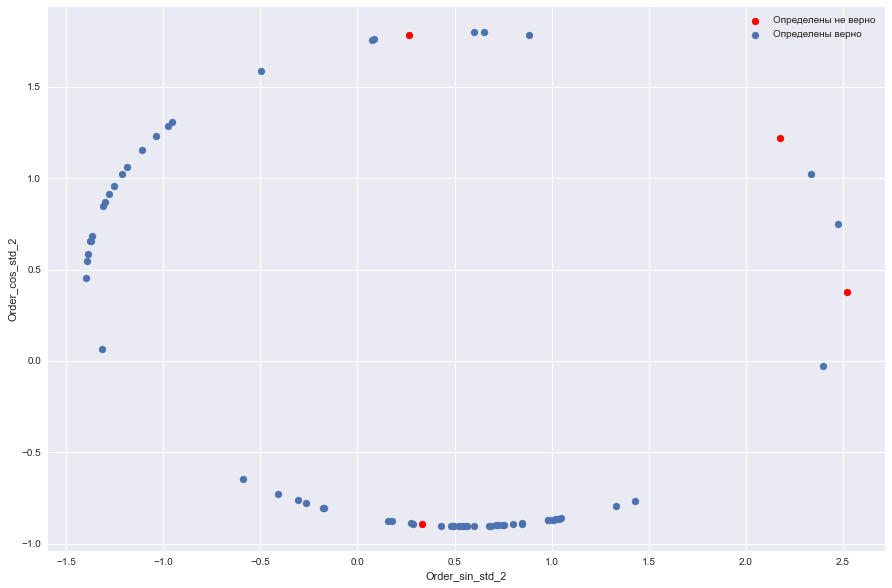

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1,Order_time_sec_delta,Order_time_sec_delta_std_delta,Delivery_time_std_delta,y_pred_delta,Correct_delta,Order_sin,Order_cos,Order_sin_std_2,Order_cos_std_2,Delivery_time_std_2,y_pred_2,Correct_2
0,0:04:24,7,1,264,-2.668392,-0.160937,1,True,81000,1.877279,-0.160937,0,False,0.019197,0.999816,0.600451,1.799814,-0.160937,1,True
1,0:10:10,5,1,610,-2.650011,-0.786802,1,True,81346,1.897805,-0.786802,0,False,0.044346,0.999016,0.649760,1.798734,-0.786802,1,True
2,0:37:54,8,1,2274,-2.561611,0.151996,1,True,83010,1.996520,0.151996,0,False,0.164617,0.986358,0.885577,1.781624,0.151996,1,True
3,3:41:23,8,0,13283,-1.976760,0.151996,1,False,7620,-2.475896,0.151996,1,False,0.822599,0.568622,2.175690,1.217011,0.151996,1,False
4,4:19:15,10,1,15555,-1.856060,0.777861,1,True,9892,-2.341113,0.777861,1,True,0.904920,0.425582,2.337098,1.023678,0.777861,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,20:37:29,12,0,74249,1.262051,1.403727,0,True,68586,1.140834,1.403727,0,True,-0.773057,0.634337,-0.952931,1.305832,1.403727,0,True
64,21:49:31,10,0,78571,1.491657,0.777861,0,True,72908,1.397232,0.777861,0,True,-0.539077,0.842256,-0.494164,1.586857,0.777861,0,True
65,23:02:09,6,1,82929,1.723175,-0.473870,0,False,77266,1.655764,-0.473870,0,False,-0.249746,0.968311,0.073130,1.757233,-0.473870,1,True
66,23:03:24,5,1,83004,1.727160,-0.786802,0,False,77341,1.660214,-0.786802,0,False,-0.244461,0.969659,0.083492,1.759054,-0.786802,1,True


In [196]:
df_test['Order_sin'] = np.sin(df_test.Order_time_sec*math.pi/43200)
df_test['Order_cos'] = np.cos(df_test.Order_time_sec*math.pi/43200)

y = 'Office'
X = ['Order_sin', 'Order_cos', 'Delivery_time']
x = ['Order_sin', 'Order_cos']
df_test = Processing_results(sc_2, lr_2, df_test, y, X, '2', [x])
df_test

In [197]:
df['Correct_2'].value_counts()

True     261
False     19
Name: Correct_2, dtype: int64

На общей выборке метрики показывают такой же результат, как и в задании 1, на тестовой выборе результат немного хуже.

---

# Задание 2

Возьмите данные со смещенным временем из задания 2. Произведите преобразование через синус и косинус. Постройте классификатор. Сравните результаты.

In [198]:
"""Решение задания 2"""
df['Order_delta_sin'] = np.sin(df.Order_time_sec_delta*math.pi/43200)
df['Order_delta_cos'] = np.cos(df.Order_time_sec_delta*math.pi/43200)
df


,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1,Order_time_sec_delta,...,Correct_delta,Order_sin,Order_cos,Order_sin_std_2,Order_cos_std_2,Delivery_time_std_2,y_pred_2,Correct_2,Order_delta_sin,Order_delta_cos
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False,80951,...,True,0.015635,0.999878,0.593465,1.799898,1.403727,0,True,-0.385973,0.922510
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True,81170,...,False,0.031556,0.999502,0.624683,1.799390,-0.473870,1,True,-0.371233,0.928540
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True,81426,...,False,0.050157,0.998741,0.661154,1.798362,0.464929,1,True,-0.353883,0.935290
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False,81564,...,True,0.060177,0.998188,0.680801,1.797614,1.403727,0,True,-0.344479,0.938794
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True,81612,...,True,0.063661,0.997972,0.687632,1.797322,-1.725600,1,True,-0.341200,0.939991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False,79491,...,True,-0.090488,0.995898,0.385390,1.794518,-1.412668,1,True,-0.481562,0.876412
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False,79592,...,False,-0.083171,0.996535,0.399737,1.795380,0.464929,0,False,-0.475112,0.879925
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False,79856,...,False,-0.064024,0.997948,0.437277,1.797290,-0.473870,1,True,-0.458133,0.888884
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False,79964,...,False,-0.056185,0.998420,0.452649,1.797928,-1.099735,1,True,-0.451137,0.892455


              precision    recall  f1-score   support

           0       0.92      0.92      0.92        25
           1       0.96      0.96      0.96        45

    accuracy                           0.94        70
   macro avg       0.94      0.94      0.94        70
weighted avg       0.94      0.94      0.94        70

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        98
           1       0.95      0.94      0.94       182

    accuracy                           0.93       280
   macro avg       0.92      0.92      0.92       280
weighted avg       0.93      0.93      0.93       280



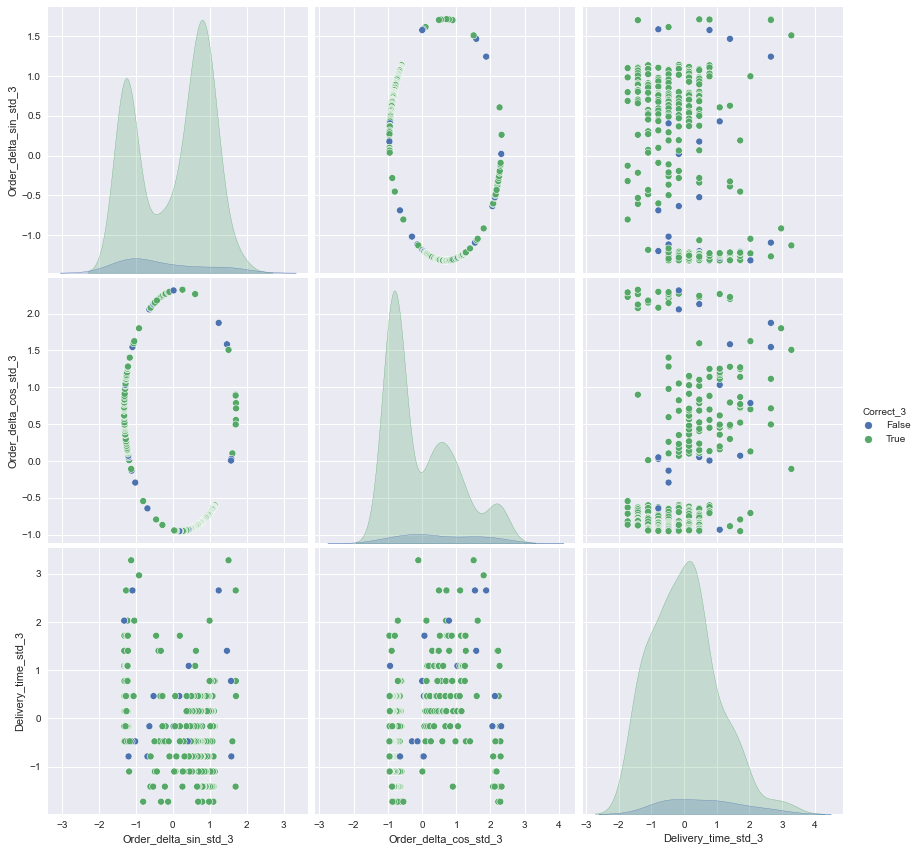

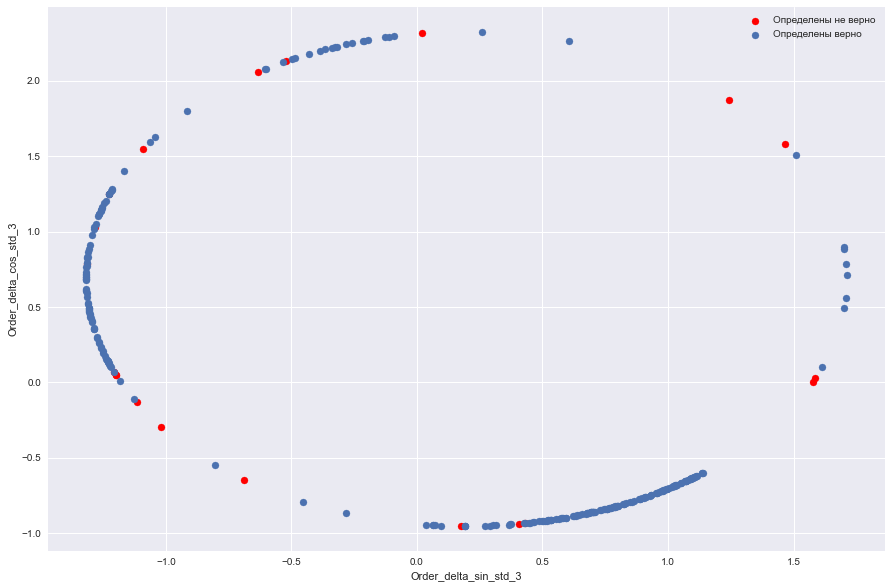

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1,Order_time_sec_delta,...,Delivery_time_std_2,y_pred_2,Correct_2,Order_delta_sin,Order_delta_cos,Order_delta_sin_std_3,Order_delta_cos_std_3,Delivery_time_std_3,y_pred_3,Correct_3
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False,80951,...,1.403727,0,True,-0.385973,0.922510,-0.387556,2.199184,1.403727,0,True
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True,81170,...,-0.473870,1,True,-0.371233,0.928540,-0.365218,2.209069,-0.473870,1,True
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True,81426,...,0.464929,1,True,-0.353883,0.935290,-0.338925,2.220135,0.464929,1,True
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False,81564,...,1.403727,0,True,-0.344479,0.938794,-0.324674,2.225880,1.403727,0,True
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True,81612,...,-1.725600,1,True,-0.341200,0.939991,-0.319705,2.227842,-1.725600,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False,79491,...,-1.412668,1,True,-0.481562,0.876412,-0.532416,2.123611,-1.412668,1,True
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False,79592,...,0.464929,0,False,-0.475112,0.879925,-0.522642,2.129371,0.464929,0,False
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False,79856,...,-0.473870,1,True,-0.458133,0.888884,-0.496910,2.144058,-0.473870,1,True
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False,79964,...,-1.099735,1,True,-0.451137,0.892455,-0.486309,2.149912,-1.099735,1,True


In [199]:
y = df.Office
X = df[['Order_delta_sin', 'Order_delta_cos', 'Delivery_time']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

sc_2 = StandardScaler()
sc_2.fit(X_train)
X_train_std = sc_2.transform(X_train)
X_test_std = sc_2.transform(X_test)

lr_2 = LogisticRegression(random_state=21)
lr_2.fit(X_train_std, y_train)

y_pred_2 = lr_2.predict(X_test_std)

print(classification_report(y_test, y_pred_2))

y = 'Office'
X = ['Order_delta_sin', 'Order_delta_cos', 'Delivery_time']
x = ['Order_delta_sin', 'Order_delta_cos']
df = Processing_results(sc_2, lr_2, df, y, X, '3', [x])
df

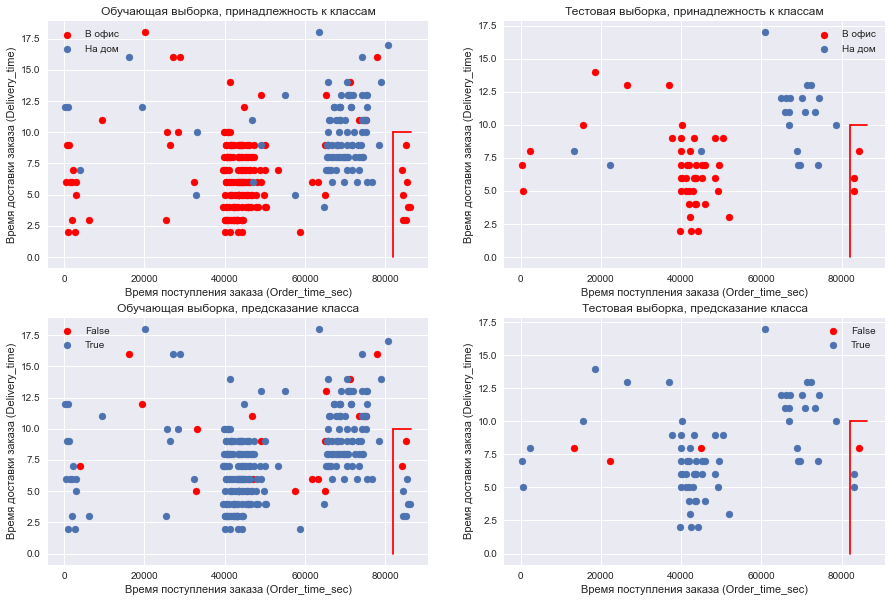

In [200]:
plt.subplot (2, 2, 1)
plt.scatter(df.Order_time_sec[df.Office == 1], df.Delivery_time[df.Office == 1], color = 'red')
plt.scatter(df.Order_time_sec[df.Office == 0], df.Delivery_time[df.Office == 0])
plt.legend(['В офис', 'На дом'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Обучающая выборка, принадлежность к классам')

plt.subplot (2, 2, 2)
plt.scatter(df_test.Order_time_sec[df_test.Office == 1], df_test.Delivery_time[df_test.Office == 1], color = 'red')
plt.scatter(df_test.Order_time_sec[df_test.Office == 0], df_test.Delivery_time[df_test.Office == 0])
plt.legend(['В офис', 'На дом'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Тестовая выборка, принадлежность к классам')

plt.subplot (2, 2, 3)
plt.scatter(df.Order_time_sec[True^df.Correct_3], df.Delivery_time[True^df.Correct_3], color = 'red')
plt.scatter(df.Order_time_sec[df.Correct_3], df.Delivery_time[df.Correct_3])
plt.legend(['False', 'True'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Обучающая выборка, предсказание класса')

plt.subplot (2, 2, 4)
plt.scatter(df_test.Order_time_sec[True^df_test.Correct_2], df_test.Delivery_time[True^df_test.Correct_2], 
            color = 'red')
plt.scatter(df_test.Order_time_sec[df_test.Correct_2], df_test.Delivery_time[df_test.Correct_2])
plt.legend(['False', 'True'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Тестовая выборка, предсказание класса')
plt.show()